# Bank Term Deposit Predictor 

##### Importing the necessary libraries

In [1]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
custom_colors = ['#AF3E3E', '#CD5656', '#E55050', '#DA6C6C', '#F49BAB', '#FFE1E0']
sns.set_palette(sns.color_palette(custom_colors))

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve,auc, precision_recall_curve

# Resampling Techniques for Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Utility
import warnings
warnings.filterwarnings('ignore')


In [2]:
# loading the dataset
bank = pd.read_csv("bank-additional-full.csv")
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Exploratory Data Analysis

In [3]:
# Check for missing values and value counts for the target
bank.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

##### This datatset has no missing values

In [4]:
# checking for duplicates
bank.duplicated().sum()

12

##### There are 12 duplicates in this dataset

In [5]:
#dropping duplicates
bank = bank.drop_duplicates()

In [6]:
#checking for to confirm if duplicates have been removed
bank.duplicated().sum()

0

##### All duplicates have been removed 

In [7]:
# Summary statistics for numeric variables
bank.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [8]:
# Unique value counts for categorical columns
categorical_cols = bank.select_dtypes(include='object').columns
categorical_cols


Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [9]:
bank['y'].value_counts(normalize=True)

y
no     0.887337
yes    0.112663
Name: proportion, dtype: float64

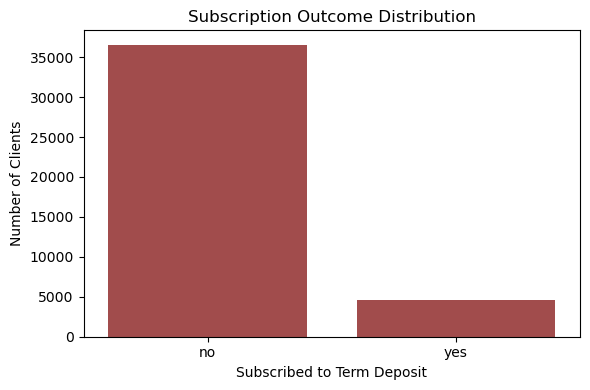

In [10]:
# checking the subscription distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=bank)
plt.title('Subscription Outcome Distribution')
plt.xlabel('Subscribed to Term Deposit')
plt.ylabel('Number of Clients')
plt.tight_layout()
plt.grid(False)
plt.show()

##### The chart shows that 88.3% of the clients did not subscribe to the term deposit while only 11.7% did. This is to say that the dataset is highly imbalanced and will need to be addressed during model training

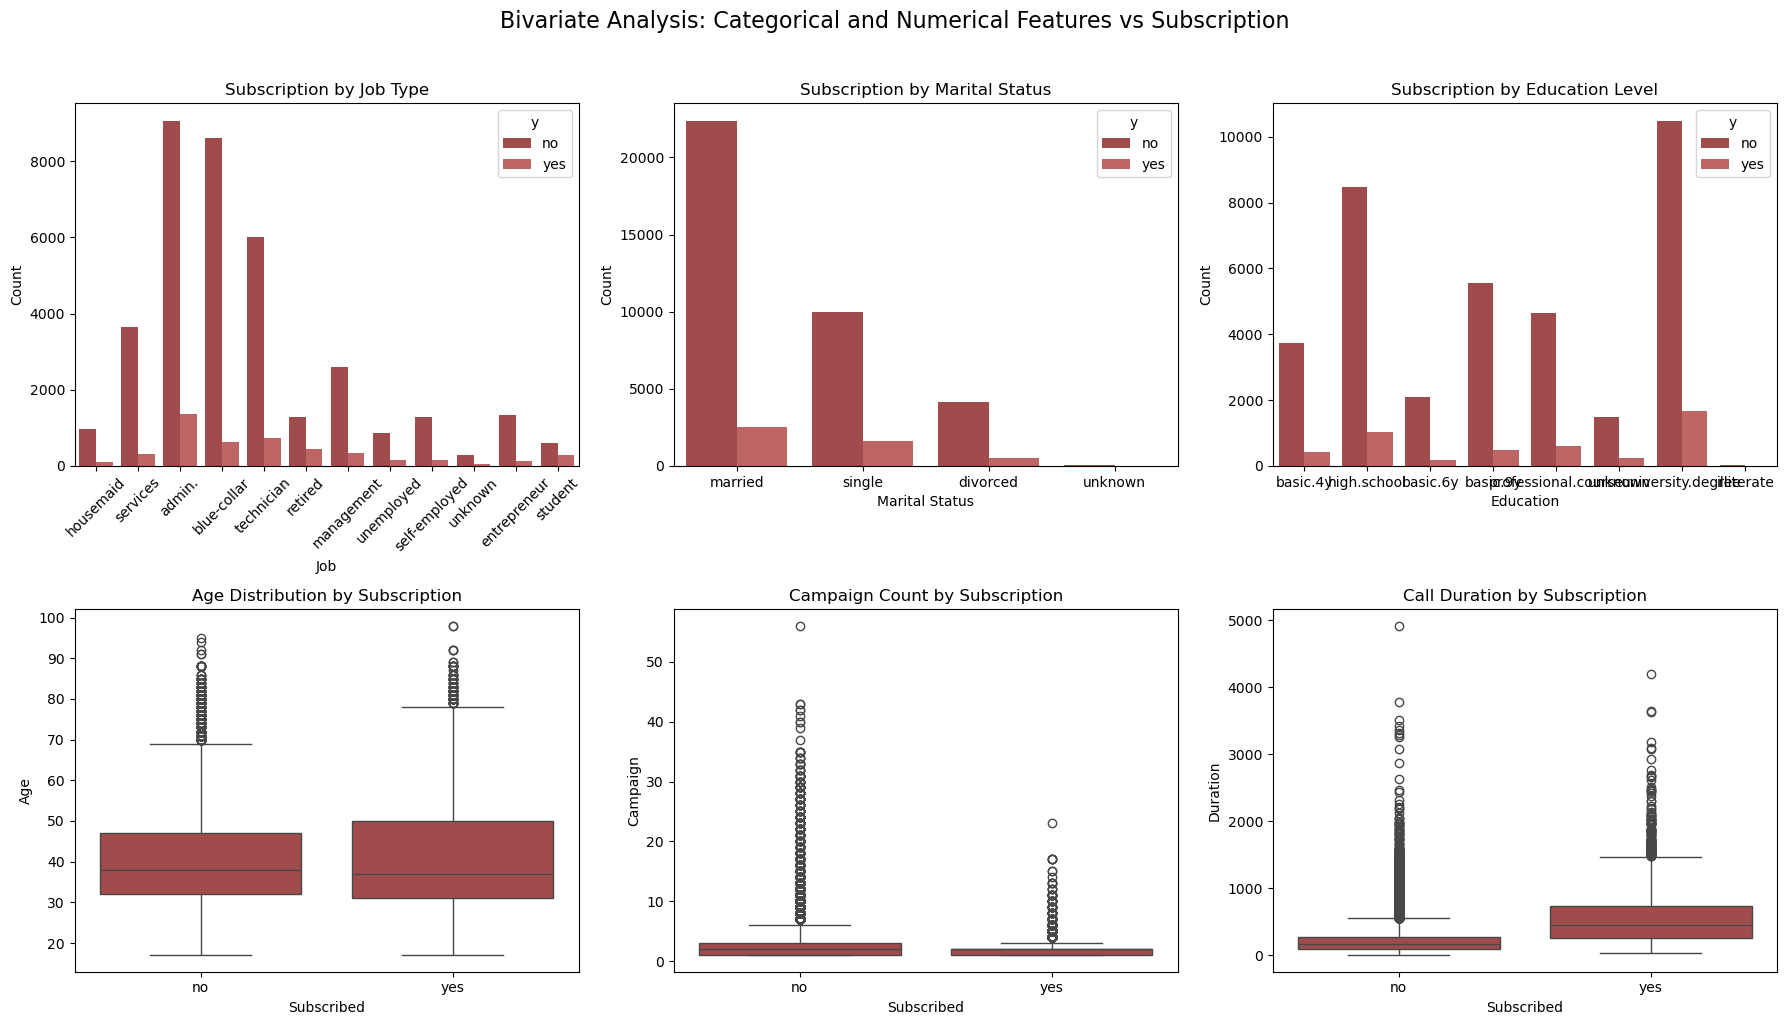

In [11]:
# Bivariate analysis: Relationship between categorical variables and subscription (target = 'y')
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Bivariate Analysis: Categorical and Numerical Features vs Subscription', fontsize=16, y=1.02)

# Plot 1: Subscription by Job
sns.countplot(data=bank, x='job', hue='y', ax=axes[0, 0])
axes[0, 0].set_title('Subscription by Job Type')
axes[0, 0].set_xlabel('Job')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Subscription by Marital Status
sns.countplot(data=bank, x='marital', hue='y', ax=axes[0, 1])
axes[0, 1].set_title('Subscription by Marital Status')
axes[0, 1].set_xlabel('Marital Status')
axes[0, 1].set_ylabel('Count')

# Plot 3: Subscription by Education Level
sns.countplot(data=bank, x='education', hue='y', ax=axes[0, 2])
axes[0, 2].set_title('Subscription by Education Level')
axes[0, 2].set_xlabel('Education')
axes[0, 2].set_ylabel('Count')

# Plot 4: Age Distribution by Subscription
sns.boxplot(x='y', y='age', data=bank, ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution by Subscription')
axes[1, 0].set_xlabel('Subscribed')
axes[1, 0].set_ylabel('Age')

# Plot 5: Campaign Distribution by Subscription (replacing balance)
sns.boxplot(x='y', y='campaign', data=bank, ax=axes[1, 1])
axes[1, 1].set_title('Campaign Count by Subscription')
axes[1, 1].set_xlabel('Subscribed')
axes[1, 1].set_ylabel('Campaign')

# Plot 6: Duration by Subscription
sns.boxplot(x='y', y='duration', data=bank, ax=axes[1, 2])
axes[1, 2].set_title('Call Duration by Subscription')
axes[1, 2].set_xlabel('Subscribed')
axes[1, 2].set_ylabel('Duration')

plt.tight_layout()
plt.show()


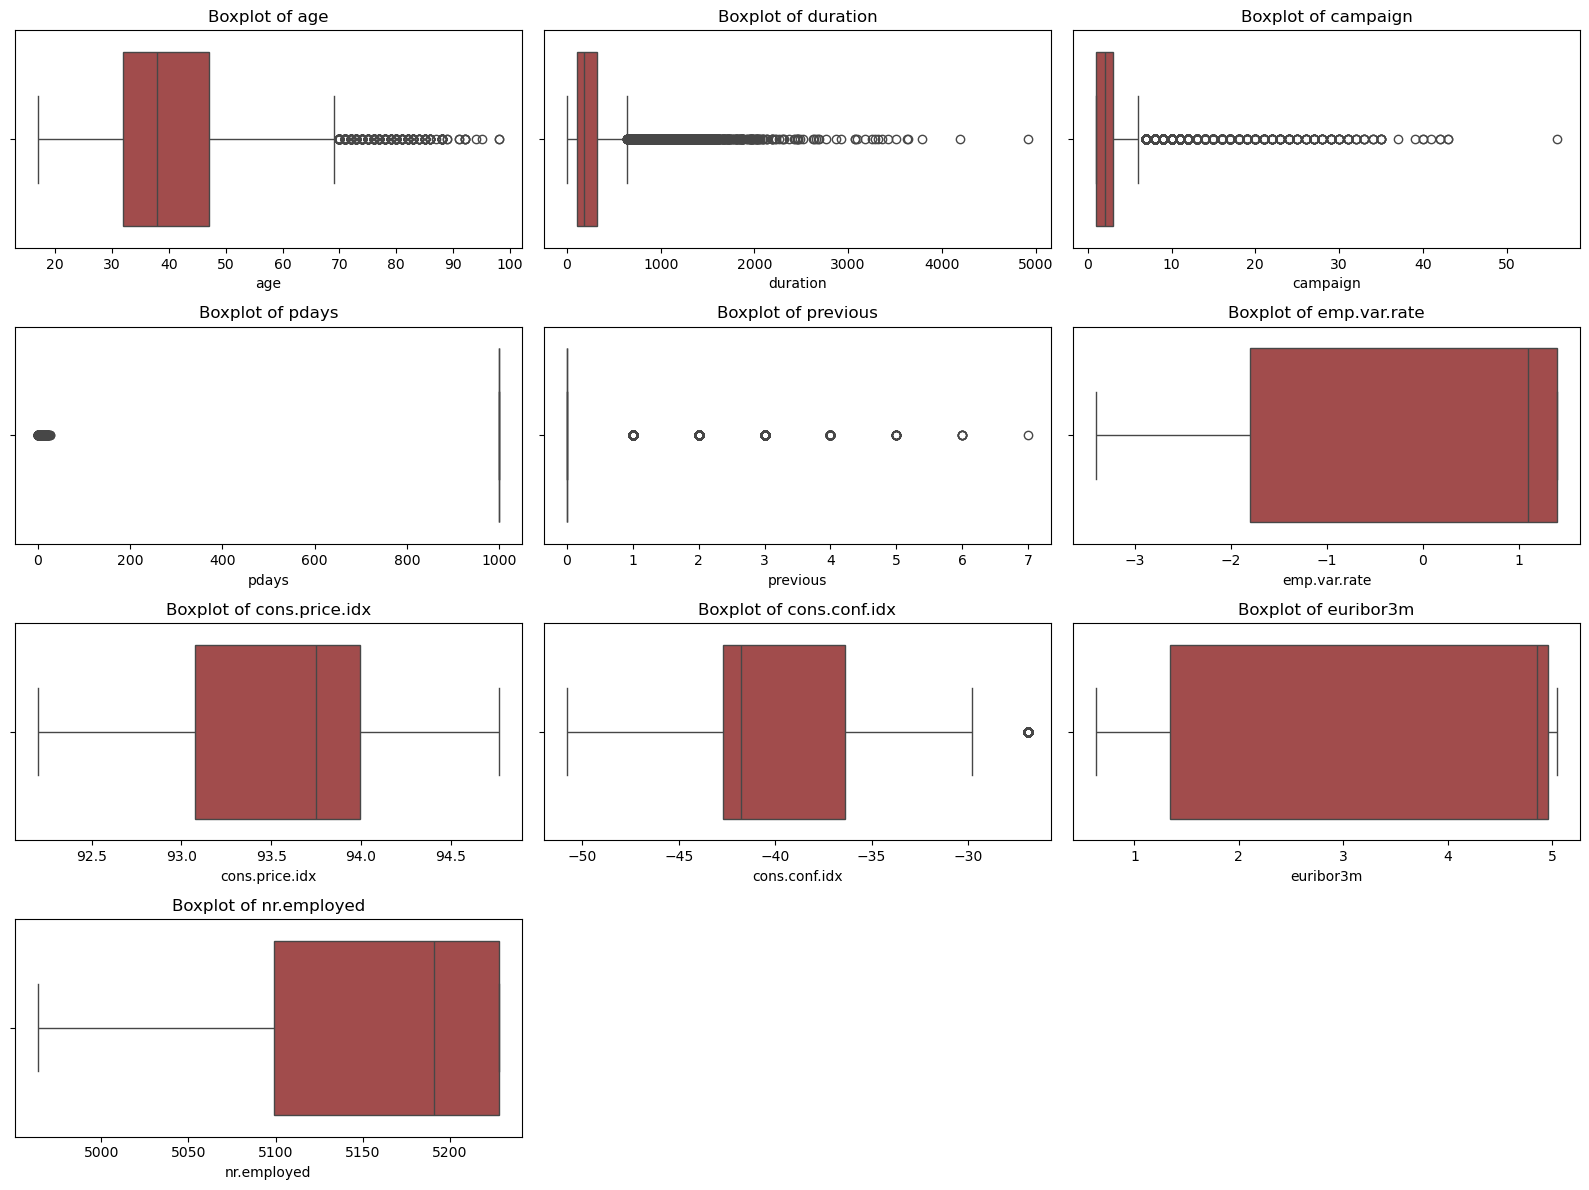

In [12]:
# Select numerical columns only
numerical_cols = bank.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Plot boxplots to identify outliers
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=bank[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.show()

In [13]:
# Re-define the DataFrame using the new name 'bank' instead of 'df'
bank = bank.copy()

# 1. Winsorization for 'age' (1st and 99th percentiles)
age_lower = bank['age'].quantile(0.01)
age_upper = bank['age'].quantile(0.99)
bank['age'] = np.clip(bank['age'], age_lower, age_upper)

# 2. Exclude 'duration' from future model use (store separately for later insights)
bank.drop(columns=['duration'], inplace=True)

# 3. Cap 'campaign' at 95th percentile
campaign_cap = bank['campaign'].quantile(0.95)
bank['campaign'] = np.clip(bank['campaign'], None, campaign_cap)

# 4. Treat 'pdays' == 999 as a separate category
bank['pdays'] = bank['pdays'].replace(999, -1)

# 5. Cap 'previous' at 95th percentile
prev_cap = bank['previous'].quantile(0.95)
bank['previous'] = np.clip(bank['previous'], None, prev_cap)

# Recalculate numerical columns after dropping 'duration'
numerical_cols_bank = bank.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Summary of changes
bank[numerical_cols_bank].describe()


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,39.976370,2.333908,-0.741913,0.136609,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.137591,1.701373,1.510540,0.343438,1.570883,0.578839,4.627860,1.734437,72.251364
min,23.000000,1.000000,-1.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,1.000000,-1.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,2.000000,-1.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,3.000000,-1.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,71.000000,7.000000,27.000000,1.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Feature Engineering

In [14]:
# Step 1: Identify categorical and numerical columns
categorical_cols = bank.select_dtypes(include='object').drop(columns='y').columns.tolist()
numerical_cols = bank.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 2: Inspect unique values in categorical columns (to inform encoding decisions)
categorical_summary = {col: bank[col].unique().tolist() for col in categorical_cols}

categorical_cols, numerical_cols, categorical_summary

(['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome'],
 ['age',
  'campaign',
  'pdays',
  'previous',
  'emp.var.rate',
  'cons.price.idx',
  'cons.conf.idx',
  'euribor3m',
  'nr.employed'],
 {'job': ['housemaid',
   'services',
   'admin.',
   'blue-collar',
   'technician',
   'retired',
   'management',
   'unemployed',
   'self-employed',
   'unknown',
   'entrepreneur',
   'student'],
  'marital': ['married', 'single', 'divorced', 'unknown'],
  'education': ['basic.4y',
   'high.school',
   'basic.6y',
   'basic.9y',
   'professional.course',
   'unknown',
   'university.degree',
   'illiterate'],
  'default': ['no', 'unknown', 'yes'],
  'housing': ['no', 'yes', 'unknown'],
  'loan': ['no', 'yes', 'unknown'],
  'contact': ['telephone', 'cellular'],
  'month': ['may',
   'jun',
   'jul',
   'aug',
   'oct',
   'nov',
   'dec',
   'mar',
   'apr',
   'sep'],
  'day_of_week': ['mon', 'tue', 'wed', 'thu', 'fri

##### 10 categorical columns, 9 numerical columns
- Target variable: y (binary: 'yes' or 'no')

In [15]:
# Binary label mapping
binary_map = {'yes': 1, 'no': 0, 'unknown': -1}
bank_binary = bank.copy()

for col in ['default', 'housing', 'loan']:
    bank_binary[col] = bank_binary[col].map(binary_map)

# Map 'contact' as binary: telephone=0, cellular=1
bank_binary['contact'] = bank_binary['contact'].map({'telephone': 0, 'cellular': 1})


In [16]:
# One-hot encoding for selected categorical variables
one_hot_cols = ['job', 'marital', 'education', 'month', 'day_of_week', 'poutcome']
bank_encoded = pd.get_dummies(bank_binary, columns=one_hot_cols, drop_first=True)

In [17]:
# Encode target variable ('y')
bank_encoded['y'] = bank_encoded['y'].map({'yes': 1, 'no': 0})

# Show shape and preview
bank_encoded.shape, bank_encoded.head(3)


((41176, 50),
    age  default  housing  loan  contact  campaign  pdays  previous  \
 0   56        0        0     0        0         1     -1         0   
 1   57       -1        0     0        0         1     -1         0   
 2   37        0        1     0        0         1     -1         0   
 
    emp.var.rate  cons.price.idx  ...  month_may  month_nov  month_oct  \
 0           1.1          93.994  ...       True      False      False   
 1           1.1          93.994  ...       True      False      False   
 2           1.1          93.994  ...       True      False      False   
 
    month_sep  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
 0      False             True            False            False   
 1      False             True            False            False   
 2      False             True            False            False   
 
    day_of_week_wed  poutcome_nonexistent  poutcome_success  
 0            False                  True             False  
 1  

### Model Training and Testing 

In [18]:
# Separate features and target
X = bank_encoded.drop('y', axis=1)
y = bank_encoded['y']

#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Show shape of splits
X_train.shape, X_test.shape, y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)


((32940, 49),
 (8236, 49),
 y
 0    0.887341
 1    0.112659
 Name: proportion, dtype: float64,
 y
 0    0.887324
 1    0.112676
 Name: proportion, dtype: float64)

- Training set: 32,950 records
- Testing set: 8,238 records
- Class distribution preserved: approximately 11.3% subscribed (y=1) in both sets due to stratification

#### Logistic Regression, Random Forest and XGBoost Model Training 

In [19]:
# Define models
log_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=8, random_state=42)

# Fit models
log_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [20]:
# Make predictions
log_preds = log_model.predict(X_test)
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

### Model Evaluation 

In [21]:
# Collect evaluation metrics
log_report = classification_report(y_test, log_preds, output_dict=True)
rf_report = classification_report(y_test, rf_preds, output_dict=True)
xgb_report = classification_report(y_test, xgb_preds, output_dict=True)

# Collect AUC scores
log_auc = roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1])
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

(log_report['1'], log_auc), (rf_report['1'], rf_auc), (xgb_report['1'], xgb_auc)


(({'precision': 0.3540810334703465,
   'recall': 0.6497844827586207,
   'f1-score': 0.4583808437856328,
   'support': 928.0},
  0.7980461451078648),
 ({'precision': 0.5501022494887525,
   'recall': 0.28987068965517243,
   'f1-score': 0.3796753705010586,
   'support': 928.0},
  0.7761566799728215),
 ({'precision': 0.36168831168831167,
   'recall': 0.6002155172413793,
   'f1-score': 0.4513776337115073,
   'support': 928.0},
  0.7871105914868921))

1. Logistic Regression:
   - Best F1-score (0.458) and AUC (0.798). Balanced trade-off between precision and recall
3. Random Forest
   - Highest precision (0.550) but lowest recall (0.289). More conservative: fewer false positives, but misses many subscribers
4. XGBoost
   - Strong recall (0.600), second-best F1 (0.451), and solid AUC (0.787). Better for detecting more subscribers (useful for campaigns)

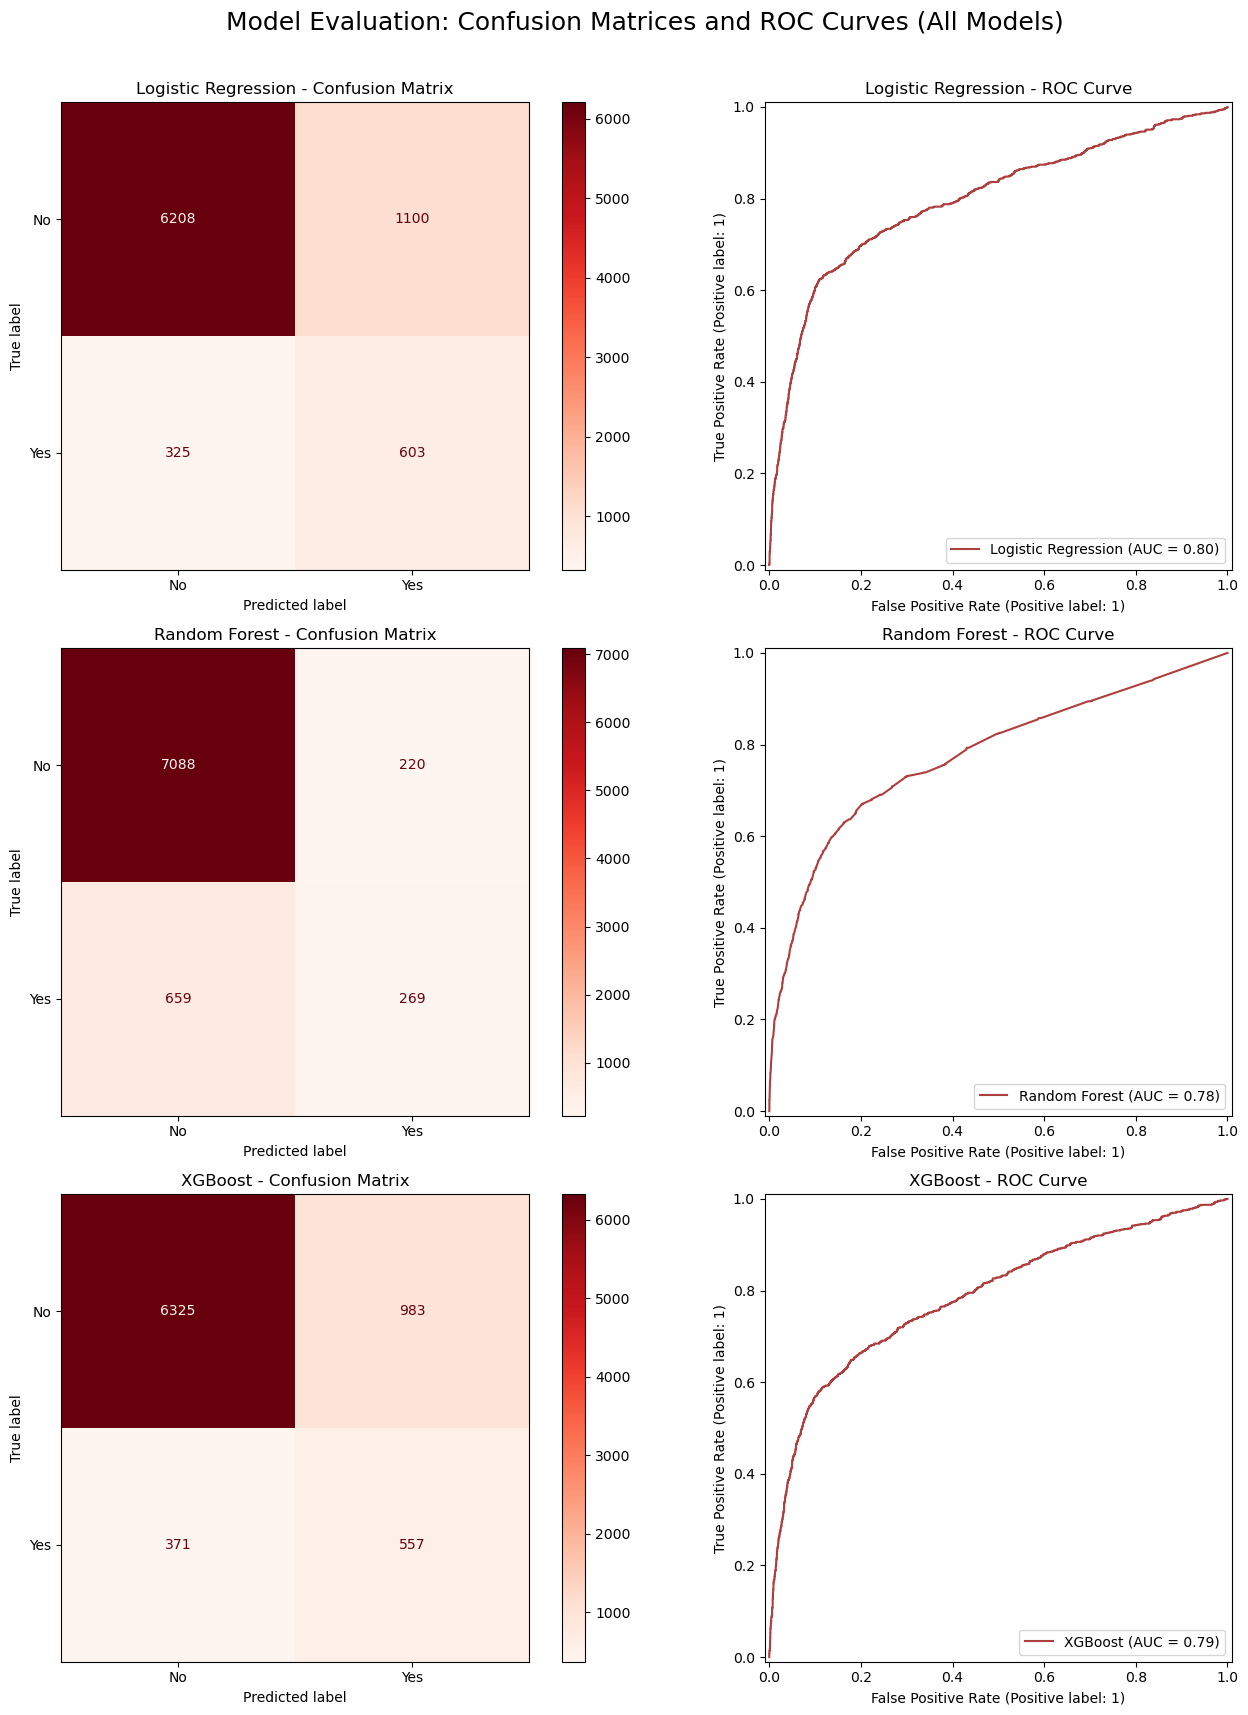

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Create 3x2 layout: [LogReg CM, LogReg ROC], [RF CM, RF ROC], [XGB CM, XGB ROC]
fig, axes = plt.subplots(3, 2, figsize=(14, 18)) 
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Logistic Regression
ConfusionMatrixDisplay.from_estimator(log_model, X_test, y_test, ax=axes[0, 0],
                                      display_labels=['No', 'Yes'], cmap='Reds')
axes[0, 0].set_title("Logistic Regression - Confusion Matrix")
RocCurveDisplay.from_estimator(log_model, X_test, y_test, ax=axes[0, 1], name='Logistic Regression')
axes[0, 1].set_title("Logistic Regression - ROC Curve")
axes[0, 1].grid(False)

# Random Forest
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, ax=axes[1, 0],
                                      display_labels=['No', 'Yes'], cmap='Reds')
axes[1, 0].set_title("Random Forest - Confusion Matrix")
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=axes[1, 1], name='Random Forest')
axes[1, 1].set_title("Random Forest - ROC Curve")
axes[1, 1].grid(False)

# XGBoost
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, ax=axes[2, 0],
                                      display_labels=['No', 'Yes'], cmap='Reds')
axes[2, 0].set_title("XGBoost - Confusion Matrix")
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, ax=axes[2, 1], name='XGBoost')
axes[2, 1].set_title("XGBoost - ROC Curve")
axes[2, 1].grid(False)

plt.suptitle("Model Evaluation: Confusion Matrices and ROC Curves (All Models)", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


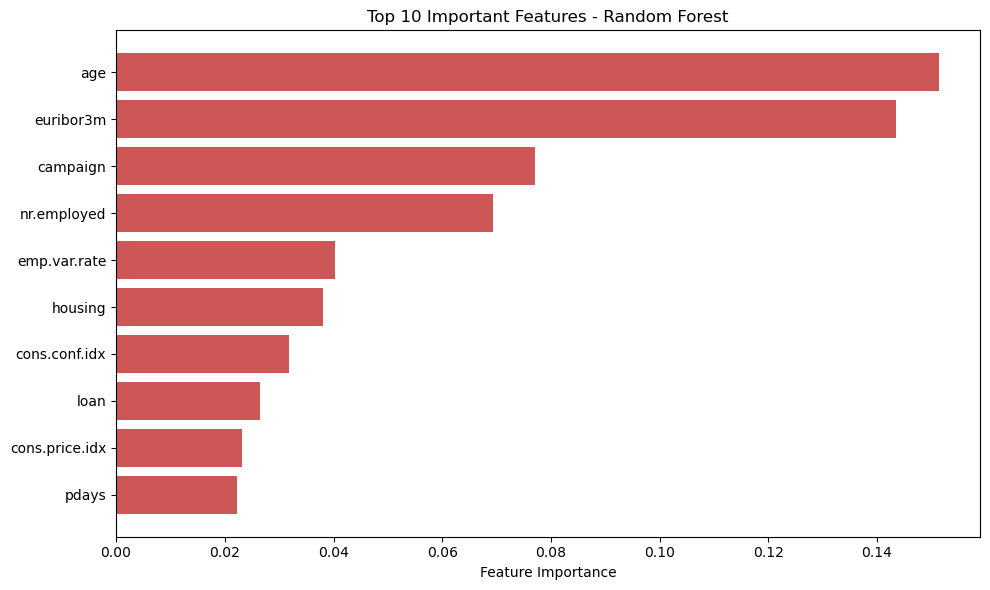

In [24]:
#Feature importance to help the bank understand which factors drive client subscriptions

import numpy as np

# Get feature importances and corresponding feature names
importances = rf_model.feature_importances_
features = X_train.columns

# Create a DataFrame for sorting and selecting top 10
importance = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

# Plot top 10 important features
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'], color='#CD5656')
plt.gca().invert_yaxis()
plt.title('Top 10 Important Features - Random Forest')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()




In [26]:
import joblib
# Save XGBoost model and feature columns
joblib.dump(xgb_model, 'xgb_subscription_model.pkl')
joblib.dump(X_train.columns.tolist(), 'xgb_model_features.pkl')


['xgb_model_features.pkl']

In [29]:
# Define the Streamlit XGBoost app code as a string
app_code = '''
import streamlit as st
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb

# Load XGBoost model and feature list
model = joblib.load('xgb_subscription_model.pkl')
feature_order = joblib.load('xgb_model_features.pkl')

st.set_page_config(page_title="Subscription Predictor", layout="centered")
st.title("💡 Term Deposit Subscription Predictor")
st.markdown("Fill in the client information below to predict subscription outcome.")

# Input UI - you can extend these as needed based on the actual features
user_inputs = {}
for feature in feature_order:
    if 'age' in feature:
        user_inputs[feature] = st.number_input('Age', min_value=18, max_value=100, value=35)
    elif 'campaign' in feature:
        user_inputs[feature] = st.slider('Campaign Contacts', 1, 10, 2)
    elif 'pdays' in feature:
        user_inputs[feature] = st.selectbox('Days Since Last Contact', [-1, 0, 1, 5, 10, 20, 999])
    elif 'previous' in feature:
        user_inputs[feature] = st.slider('Previous Contacts', 0, 10, 0)
    elif 'euribor3m' in feature:
        user_inputs[feature] = st.number_input('Euribor 3-month Rate', 0.0, 6.0, 4.0)
    elif 'emp.var.rate' in feature:
        user_inputs[feature] = st.number_input('Employment Variation Rate', -5.0, 2.0, 1.1)
    elif 'contact' in feature:
        user_inputs[feature] = st.radio("Contact Type", [0, 1])  # 0=Telephone, 1=Cellular
    else:
        user_inputs[feature] = st.number_input(feature, value=0.0)

# Convert input to DataFrame
input_df = pd.DataFrame([user_inputs])[feature_order]

# Prediction
if st.button("Predict Subscription"):
    prediction = model.predict(input_df)[0]
    probability = model.predict_proba(input_df)[0][1]
    
    st.subheader("📊 Prediction Result")
    st.write(f"**Prediction:** {'✅ Yes' if prediction == 1 else '❌ No'}")
    st.write(f"**Subscription Probability:** {probability:.2%}")
'''

# Save the app code to a file
with open("xgboost_app.py", "w", encoding="utf-8") as f:
    f.write(app_code)

"xgboost_app.py"


'xgboost_app.py'